[0]	train-rmse:0.20853	eval-rmse:0.13392
[1]	train-rmse:0.20738	eval-rmse:0.13360
[2]	train-rmse:0.20619	eval-rmse:0.13450
[3]	train-rmse:0.20532	eval-rmse:0.13412
[4]	train-rmse:0.20403	eval-rmse:0.13353
[5]	train-rmse:0.20279	eval-rmse:0.13221
[6]	train-rmse:0.20178	eval-rmse:0.13251
[7]	train-rmse:0.20053	eval-rmse:0.13252
[8]	train-rmse:0.19936	eval-rmse:0.13220
[9]	train-rmse:0.19813	eval-rmse:0.13285
[10]	train-rmse:0.19730	eval-rmse:0.13251
[11]	train-rmse:0.19587	eval-rmse:0.13107
[12]	train-rmse:0.19463	eval-rmse:0.13110
[13]	train-rmse:0.19331	eval-rmse:0.13027
[14]	train-rmse:0.19198	eval-rmse:0.12857
[15]	train-rmse:0.19070	eval-rmse:0.12725
[16]	train-rmse:0.18934	eval-rmse:0.12635
[17]	train-rmse:0.18810	eval-rmse:0.12635
[18]	train-rmse:0.18738	eval-rmse:0.12767
[19]	train-rmse:0.18640	eval-rmse:0.12659
[20]	train-rmse:0.18503	eval-rmse:0.12587
[21]	train-rmse:0.18372	eval-rmse:0.12496
[22]	train-rmse:0.18245	eval-rmse:0.12438
[23]	train-rmse:0.18132	eval-rmse:0.12394
[2

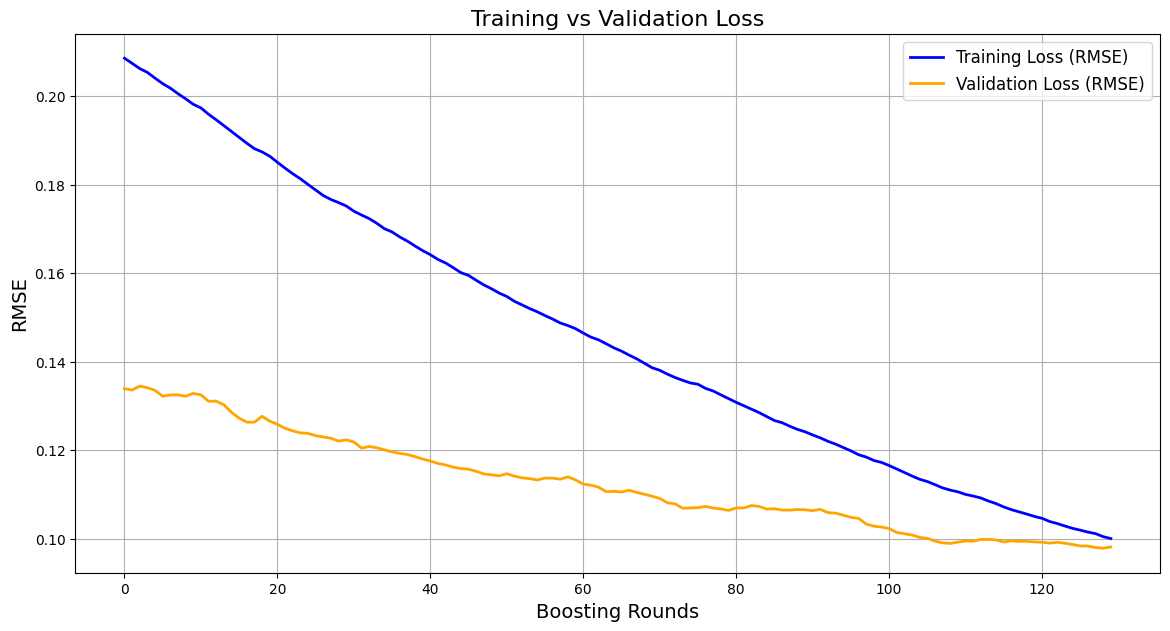

c:\Users\a\anaconda3\envs\lstm\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\lstm\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\lstm\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\lstm\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\a\anaconda3\envs\lstm\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45796 (\N{HANGUL SYLLABLE DA}) missing from font(s) DejaVu Sans.
  fig.

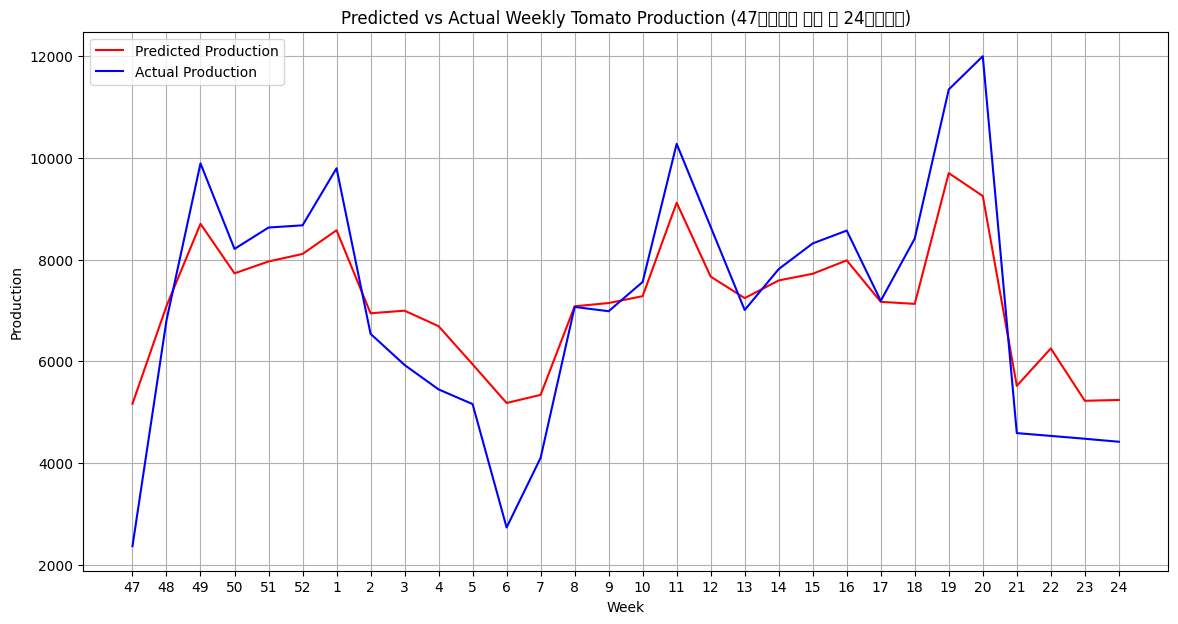

In [13]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from xgboost import DMatrix, train
import matplotlib.pyplot as plt

# 데이터 불러오기
yield_data = pd.read_csv('전북군산생산량_변환.csv')
env_data = pd.read_csv('전북군산환경데이터_변환.csv')

# 2. 날짜 데이터를 변환하고 주차 계산
env_data['measDtStr'] = pd.to_datetime(env_data['measDtStr'], format='%Y%m%d%H%M%S')
env_data['연도'] = env_data['measDtStr'].dt.year
env_data['주차'] = env_data['measDtStr'].dt.isocalendar().week

# 3. 주차별로 평균, 최소, 최대값 계산
env_weekly_features = env_data.groupby(['연도', '주차']).agg({
    'inTp': ['mean', 'min', 'max'],  # 온도 (평균, 최소, 최대)
    'inHd': ['mean', 'min', 'max'],  # 습도 (평균, 최소, 최대)
    'inCo2': ['mean', 'min', 'max'],  # CO2 농도 (평균, 최소, 최대)
    'outTp': ['mean', 'min', 'max']  # 외부 온도 (평균, 최소, 최대)
}).reset_index()

# 열 이름을 단순화
env_weekly_features.columns = [
    '연도', '주차',
    'inTp_mean', 'inTp_min', 'inTp_max',       # 내부 온도 열
    'inHd_mean', 'inHd_min', 'inHd_max',       # 내부 습도 열
    'inCo2_mean', 'inCo2_min', 'inCo2_max',    # CO2 농도 열
    'outTp_mean', 'outTp_min', 'outTp_max'     # 외부 온도 열
]

# 4. 생산량 데이터 병합 (면적 제외)
yield_data = yield_data.rename(columns={'item.frmhsId': 'frmhsId'})  # 열 이름 통일
merged_data = pd.merge(
    env_weekly_features,
    yield_data[['연도', '주차', '생산량']],
    on=['연도', '주차'],
    how='inner'
).dropna(subset=['생산량'])  # 결측치 제거

# 5. 특성과 타겟 데이터 분리
X = merged_data[['inTp_mean', 'inTp_min', 'inTp_max', 
                 'inHd_mean', 'inHd_min', 'inHd_max', 
                 'inCo2_mean', 'inCo2_min', 'inCo2_max', 
                 'outTp_mean', 'outTp_min', 'outTp_max']].values
y = merged_data['생산량'].values

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 타겟 데이터 스케일링
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# 시계열 데이터 준비
timesteps = 12  # 12주 간 데이터를 사용
forecast_weeks = 1  # 1주차 예측

# 시퀀스를 생성
X_sequences = []
y_sequences = []
for i in range(len(X_scaled) - timesteps - forecast_weeks + 1):
    X_sequences.append(X_scaled[i:i+timesteps].flatten())  # 시계열 데이터를 1D로 펼침
    y_sequences.append(y_scaled[i+timesteps:i+timesteps+forecast_weeks].flatten())

# 시퀀스를 넘파이 배열로 변환
X_sequences = np.array(X_sequences)
y_sequences = np.array(y_sequences).flatten()

# 학습 데이터와 테스트 데이터로 분할 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_sequences, y_sequences, test_size=0.2, random_state=42)

# XGBoost DMatrix 생성
dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

# XGBoost 파라미터 설정
params = {
    'objective': 'reg:squarederror',  # 회귀 문제
    'eval_metric': 'rmse',           # 평가 지표
    'learning_rate': 0.01,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

# 평가 데이터 설정
evals = [(dtrain, 'train'), (dtest, 'eval')]

# 손실 기록용 evals_result 초기화
evals_result = {}

# 모델 학습
model = train(
    params,
    dtrain,
    num_boost_round=130,
    evals=evals,
    early_stopping_rounds=50,  # 성능 향상이 없으면 중단
    evals_result=evals_result,  # 손실 기록 저장
    verbose_eval=True
)

# 학습 및 검증 손실 시각화
def plot_training_validation_loss(evals_result):
    train_rmse = evals_result['train']['rmse']
    eval_rmse = evals_result['eval']['rmse']

    plt.figure(figsize=(14, 7))
    plt.plot(train_rmse, label='Training Loss (RMSE)', color='blue', linewidth=2)
    plt.plot(eval_rmse, label='Validation Loss (RMSE)', color='orange', linewidth=2)
    plt.title('Training vs Validation Loss', fontsize=16)
    plt.xlabel('Boosting Rounds', fontsize=14)
    plt.ylabel('RMSE', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

# 손실 데이터 가져오기 및 그래프 출력
plot_training_validation_loss(evals_result)

# 예측 수행
y_pred = model.predict(DMatrix(X_test))
y_pred_inverse = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
y_test_inverse = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# 주차별 예측된 생산량 출력 (47주차부터 다음 해 24주차까지)
weeks_extended_full = np.concatenate([np.arange(47, 53), np.arange(1, 25)])  # 47주차부터 다음 해 24주차까지
X_full_sequences = np.array([X_scaled[i:i+timesteps].flatten() for i in range(len(X_scaled) - timesteps + 1)])
full_predictions = model.predict(DMatrix(X_full_sequences))
full_predictions_inverse = scaler_y.inverse_transform(full_predictions.reshape(-1, 1))

# 실제 생산량 데이터 로드 및 주차 필터링
filtered_yield_data = yield_data[(yield_data['주차'] >= 47) | (yield_data['주차'] <= 24)]
filtered_yield_data = filtered_yield_data.sort_values(by=['연도', '주차'])
actual_production = filtered_yield_data['생산량'].values[:len(weeks_extended_full)]

# 주차별 예측값 시각화
plt.figure(figsize=(14, 7))
plt.plot(np.arange(len(weeks_extended_full)), full_predictions_inverse.flatten()[:len(weeks_extended_full)], label='Predicted Production', color='red')
plt.plot(np.arange(len(weeks_extended_full)), actual_production, label='Actual Production', color='blue')
plt.xticks(ticks=np.arange(len(weeks_extended_full)), labels=weeks_extended_full)
plt.title('Predicted vs Actual Weekly Tomato Production (47주차부터 다음 해 24주차까지)')
plt.xlabel('Week')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# 학습 상태 판별 함수 기본적으로 
def check_training_status(evals_result, threshold=0.1):
    train_rmse = evals_result['train']['rmse']
    eval_rmse = evals_result['eval']['rmse']
    
    # 마지막 값 기준
    train_last = train_rmse[-1]
    eval_last = eval_rmse[-1]
    loss_difference = eval_last - train_last

    # 상태 판별
    if abs(loss_difference) > threshold * train_last and eval_last > train_last:
        status = "과대적합"
    elif train_last > 0.2 and eval_last > 0.2:  # 손실이 여전히 높은 경우
        status = "과소적합"
    else:
        status = "정상"

    print("Training Loss (RMSE):", train_last)
    print("Validation Loss (RMSE):", eval_last)
    print("Loss Difference:", loss_difference)
    print("Training Status:", status)
    
    return {
        'train_loss': train_last,
        'validation_loss': eval_last,
        'loss_difference': loss_difference,
        'status': status
    }

# 학습 상태 확인
training_status = check_training_status(evals_result, threshold=0.1)

# 결과 출력
print(training_status)


Training Loss (RMSE): 0.1000725261506157
Validation Loss (RMSE): 0.09816694260763048
Loss Difference: -0.0019055835429852147
Training Status: 정상
{'train_loss': 0.1000725261506157, 'validation_loss': 0.09816694260763048, 'loss_difference': -0.0019055835429852147, 'status': '정상'}
